In [7]:
import os 
import sys 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, fpmax, association_rules

---
Module building

In [30]:
class RuleMiningAnalyzer(object):
    def __init__(self, train_df, user_col, item_col, rating_col, is_prep=False, te=None):
        self.ref_df = train_df
        self.user_col = user_col
        self.item_col = item_col
        self.rating_col = rating_col 
        if is_prep:
            self.df = self.ref_df.copy()
            self.te = te
        else:
            self.df, self.te = self.generateOneHotdf(self.ref_df, self.user_col, self.item_col)

    def generateOneHotdf(self, df, user_col, item_col, te=None):
        df = df.copy()
        df[item_col] = df[item_col].astype(str)
        user_item_mapper = df.groupby(user_col)[item_col].apply(list).reset_index()
        title_list = user_item_mapper[item_col].values
        if te == None:
            te = TransactionEncoder()
            te_ary = te.fit(title_list).transform(title_list)
        else:
            te_ary = te.transform(title_list)
        dummy_df = pd.DataFrame(te_ary, columns=te.columns_)
        return dummy_df, te

    def rule_mining(self, df, algo='apriori', rule_len=2, min_support=0.05):
        df = df.copy()
        if algo == 'apriori':
            freq_rules = apriori(df.copy(), min_support=min_support, use_colnames=True, max_len=rule_len)
        elif algo == 'fpgrowth':
            freq_rules = fpgrowth(df.copy(), min_support=min_support, use_colnames=True, max_len=rule_len)
        elif algo == 'fpmax':
            freq_rules = fpmax(df.copy(), min_support=min_support, use_colnames=True, max_len=rule_len)
        
        rules = association_rules(freq_rules, metric='lift', min_threshold=min_support) # metrics : [support, confidence, lift]
        return rules 

    def __kl_divergence(self, a, b):
        return sum(a[i] * np.log(a[i]/b[i]) for i in range(len(a)))

    def get_rule_report(self):
        return self.rule_mining(self.df)

    def pop_item_rules(self, item_id, n_rules, algo='apriori'):
        rules = self.rule_mining(self.df, algo=algo)
        
        pop_rules = rules[rules["antecedents"].apply(lambda x: item_id in str(x))].groupby(
                ['antecedents', 'consequents'])[['confidence']].max().sort_values(ascending=False,
                                                                                by='confidence').head(n_rules).reset_index()
        return pop_rules 

    def draw_rule_map(self, n_rules, sort_by='lift', algo='apriori'):
        rules = self.rule_mining(self.df, algo=algo)
        rules['antecedents'] = rules.antecedents.apply(lambda x: next(iter(x)))
        rules['consequents'] = rules.consequents.apply(lambda x: next(iter(x)))

        plt.figure(figsize=(15,15))
        plt.style.use('fivethirtyeight')
        edges = nx.from_pandas_edgelist(rules.sort_values(ascending=False,by=sort_by).head(n_rules) ,source='antecedents',target='consequents',edge_attr=None, create_using=nx.DiGraph())
        # plt.subplots(figsize=(40,30))
        plt.suptitle('Associations between movies', fontsize = 20,fontweight = 'bold')
        pos = nx.nx_pydot.pydot_layout(edges)
        nx.draw_networkx_nodes(edges, pos, node_size = 1000,alpha= 0.7,node_color = 'tomato')
        nx.draw_networkx_edges(edges, pos, width = 4, alpha = 0.2, edge_color = 'indigo', arrows=True, arrowsize=20)
        nx.draw_networkx_labels(edges, pos, font_size = 15, font_family = 'FreeMono',)
        plt.grid()
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def discrepancy_report(self, test_df):
        train_rules = self.rule_mining(self.df)

        pred_tfd, _ = self.generateOneHotdf(test_df, self.user_col, self.item_col)
        pred_rules = self.rule_mining(pred_tfd)

        train_rules['x'] = train_rules['antecedents'].apply(lambda x: list(x)[0])
        train_rules['y'] = train_rules['consequents'].apply(lambda x: list(x)[0])
        pred_rules['x'] = pred_rules['antecedents'].apply(lambda x: list(x)[0])
        pred_rules['y'] = pred_rules['consequents'].apply(lambda x: list(x)[0])

        ## analyze rule support discrepancy 
        train_rules['id'] = train_rules[['x', 'y']].apply(lambda x: f'{x[0]}-{x[1]}', axis=1)
        pred_rules['id'] = pred_rules[['x', 'y']].apply(lambda x: f'{x[0]}-{x[1]}', axis=1)
        train_rule_dist = pd.Series(data=train_rules['support'].values, index=train_rules['id']).to_dict()
        pred_rule_dist = pd.Series(data=pred_rules['support'].values, index=pred_rules['id']).to_dict()
        train_rule_set = set(train_rule_dist.keys())
        pred_rule_set = set(pred_rule_dist.keys())

        common_rules = train_rule_set & pred_rule_set
        vanished_rules = train_rule_set - pred_rule_set
        introduced_rules = pred_rule_set - train_rule_set

        updated_train_dist = {k:v for k,v in train_rule_dist.items() if k in common_rules}
        update_pred_dist = {k:v for k,v in pred_rule_dist.items() if k in common_rules}
        train_prob_dist = np.array(list(updated_train_dist.values()))
        pred_prob_dist = np.array(list(update_pred_dist.values()))

        ks_distance = stats.ks_2samp(train_prob_dist, pred_prob_dist) 
        wasse_distance = stats.wasserstein_distance(train_prob_dist, pred_prob_dist)
        energy_distance = stats.energy_distance(train_prob_dist, pred_prob_dist)
        kl_divergance = self.__kl_divergence(train_prob_dist, pred_prob_dist)

        report = {
            '#train-prediction common rules': len(common_rules),
            '# rules missing in prediction from train': len(vanished_rules),
            '# rules introduced in the prediction': len(introduced_rules),
            'Kolmogorov metric': ks_distance,
            'Wasserstein distance': wasse_distance,
            'Energy metric distance': energy_distance,
            'KL-divergance': kl_divergance
        }
        return report



    

---
Data loading

In [17]:
train_df = pd.read_csv('../data/ml_100k/train_data.csv')
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], unit='s')
print("Training Data > \n", train_df.head())


test_df = pd.read_csv('../data/ml_100k/test_data.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='s')
print("Test Data > \n", test_df.head())

pred_df = pd.read_csv('../data/ml_100k/predicted_data.csv')
pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp'], unit='s')
print("Predicted Results > \n", pred_df.head())

Training Data > 
    user_id  item_id  rating           timestamp
0        1        1       5 1997-09-22 22:02:38
1        1        2       3 1997-10-15 05:26:11
2        1        3       4 1997-11-03 07:42:40
3        1        4       3 1997-10-15 05:25:19
4        1        5       3 1998-03-13 01:15:12
Test Data > 
    user_id  item_id  rating           timestamp
0        1        6       5 1998-02-14 04:52:53
1        1       10       3 1997-10-01 08:05:18
2        1       12       5 1997-11-03 07:42:40
3        1       14       5 1997-09-22 22:01:46
4        1       17       3 1997-09-24 03:53:18
Predicted Results > 
    user_id  item_id  score  rating           timestamp
0        1        6      4       5 1998-02-14 04:52:53
1        1       10      4       3 1997-10-01 08:05:18
2        1       12      4       5 1997-11-03 07:42:40
3        1       14      4       5 1997-09-22 22:01:46
4        1       17      3       3 1997-09-24 03:53:18


---
Module testing

In [31]:
ruleAnalyzer = RuleMiningAnalyzer(train_df, user_col='user_id', item_col='item_id', rating_col='rating')

In [32]:
ruleAnalyzer.get_rule_report()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(100),(1),0.418876,0.406151,0.238600,0.569620,1.402485,0.068474,1.379827
1,(1),(100),0.406151,0.418876,0.238600,0.587467,1.402485,0.068474,1.408674
2,(1),(1011),0.406151,0.085896,0.058324,0.143603,1.671824,0.023438,1.067384
3,(1011),(1),0.085896,0.406151,0.058324,0.679012,1.671824,0.023438,1.850069
4,(1012),(1),0.086957,0.406151,0.066808,0.768293,1.891645,0.031491,2.562929
...,...,...,...,...,...,...,...,...,...
40201,(98),(97),0.318134,0.220573,0.141039,0.443333,2.009920,0.070868,1.400169
40202,(97),(99),0.220573,0.144221,0.082715,0.375000,2.600184,0.050904,1.369247
40203,(99),(97),0.144221,0.220573,0.082715,0.573529,2.600184,0.050904,1.827623
40204,(98),(99),0.318134,0.144221,0.094380,0.296667,2.057034,0.048498,1.216748


In [33]:
ruleAnalyzer.pop_item_rules('12', n_rules=10)

,antecedents,consequents,confidence
0,(122),(50),0.823529
1,(122),(121),0.811765
2,(123),(50),0.800000
3,(312),(313),0.790323
4,(1012),(1),0.768293
5,(12),(50),0.763033
6,(412),(181),0.760000
7,(127),(50),0.750000
8,(124),(100),0.750000
9,(123),(1),0.747368


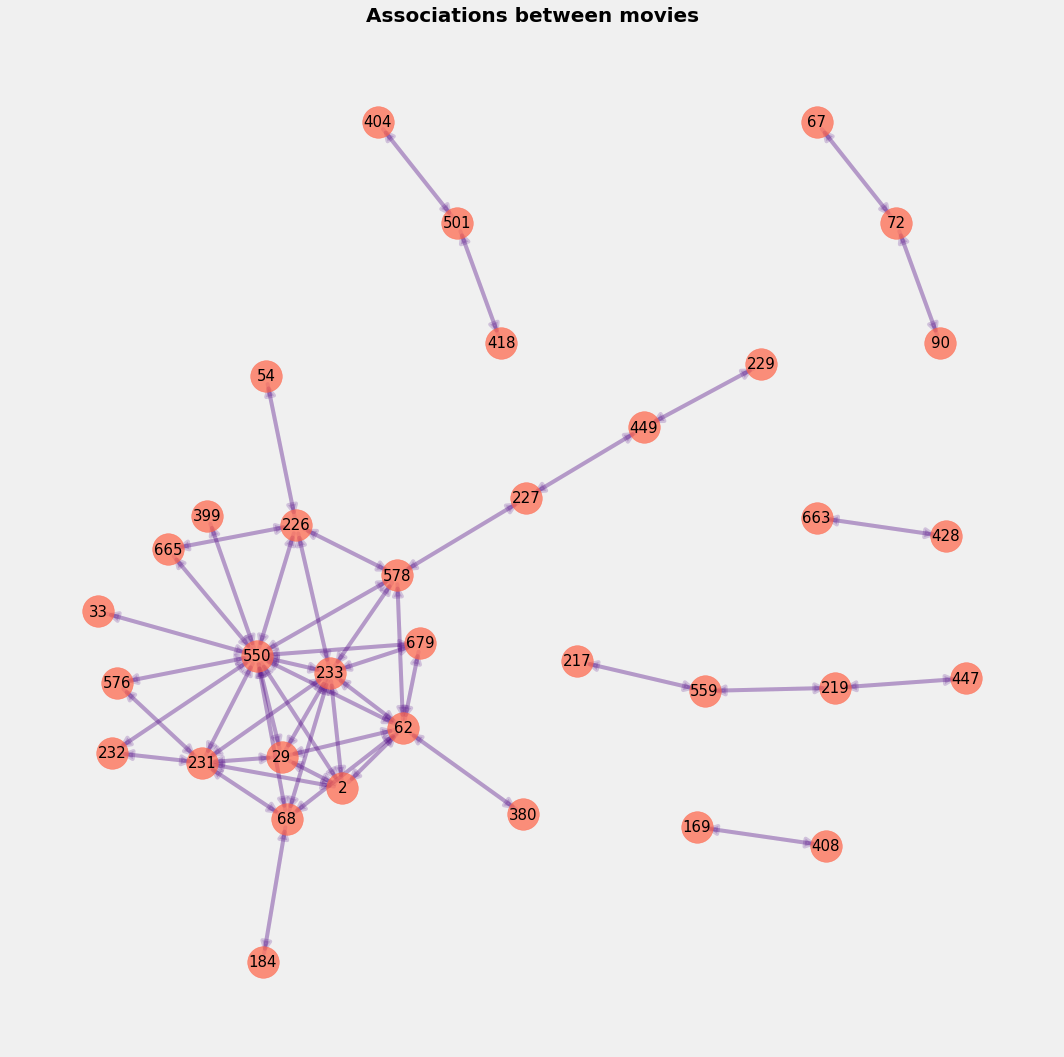

In [34]:
ruleAnalyzer.draw_rule_map(100)

In [35]:
test1_df = test_df.loc[test_df['user_id']!='599', :]

ruleAnalyzer.discrepancy_report(test1_df)

{'#train-prediction common rules': 278,
 '# rules missing in prediction from train': 39928,
 '# rules introduced in the prediction': 0,
 'Kolmogorov metric': KstestResult(statistic=1.0, pvalue=2.5069462176079497e-166),
 'Wasserstein distance': 0.1244697045889789,
 'Energy metric distance': 0.43885700670120914,
 'KL-divergance': 60.452213861435126}